# Desharnais

In [1]:
dataset = "desharnais_pre"

time: 4.26 ms


## Rohe Daten
Baue Datenbankverbindung auf und zeige 3 Beispieldaten aus dem Datensatz "Desharnais".

In [2]:
from libs.data.Db import Db
import pandas as pd

db = Db().getDb()
coll = db[dataset]

# data is already filtered, one hot encoded and normalized
list(coll.find().limit(3))

[{'_id': ObjectId('5c9b93e1464077001349edcb'),
  'Effort': 5152.0,
  'Project': 1.0,
  'id': 1.0,
  'Entities': -0.8012587574370996,
  'Envergure': 0.6256714445467177,
  'Length': 0.10401747754604197,
  'ManagerExp': 0.8945595320809094,
  'PointsAdjust': 0.10591863402422147,
  'PointsNonAdjust': 0.03858613239441162,
  'TeamExp': -0.9839927200551897,
  'Transactions': 0.5204504967277443,
  'Is_BasicCobol': 1.0,
  'Is_AdvancedCobol': 0.0,
  'Is_4GL': 0.0},
 {'_id': ObjectId('5c9b93e1464077001349edcc'),
  'Effort': 5635.0,
  'Project': 2.0,
  'id': 2.0,
  'Entities': 0.0403817410909944,
  'Envergure': 0.5300827516298581,
  'Length': -1.0825522663125124,
  'ManagerExp': -1.754712928312553,
  'PointsAdjust': 0.17613356955948342,
  'PointsNonAdjust': 0.12694694114890084,
  'TeamExp': -1.7416671144976856,
  'Transactions': 0.13458692350043458,
  'Is_BasicCobol': 1.0,
  'Is_AdvancedCobol': 0.0,
  'Is_4GL': 0.0},
 {'_id': ObjectId('5c9b93e1464077001349edcd'),
  'Effort': 805.0,
  'Project': 3.0

time: 923 ms


## Data

In [3]:
import pandas as pd

data = pd.DataFrame(
    list(coll.find({}, { 'Project': 0, '_id': 0 }))
)

time: 9.39 ms


## Decision Trees

### Bootstrapping

In [4]:
from sklearn.utils import resample
import numpy as np
from libs.evaluation.Metrics import Metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
import pandas as pd
import matplotlib.pyplot as plt

def my_scorer(y_true, y_pred):
    return Metrics().pred(y_true, y_pred)

m_b = {
    'mmre': [],
    'mdmre': [],
    'pred': [],
    'mmer': [],
    'mdmer': [],
    'mae': [],
    'mbre': [],
    'mibre': [],
    'sa': []
}
n = 30
for i in range(n):
    print("{} from {}".format(i+1, n))
    train = resample(np.array(data), n_samples=len(data), replace=True)
    X_train = train[:,1:]
    y_train = train[:,0]
    test = np.array([x for x in np.array(data) if x.tolist() not in train.tolist()])
    X_test = test[:,1:]
    y_test = test[:,0]

    searchSpace = {
        "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, None], 
        "min_samples_split": [0.05, 0.1, 0.15, 0.2, 0.3],
        "min_samples_leaf": [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5],
        "max_features": range(1, len(data.columns)),
        "criterion": ["mse", "mae"],
        "max_leaf_nodes": [2, 5, 10, 15, 20, None] # 2 provocates a max_depth of 1, which wouldn't be tested due to a bug, see: https://github.com/scikit-learn/scikit-learn/issues/13149
        # do not test splitter here, see: https://stackoverflow.com/a/46759065
    }
    
    rs_b = RandomizedSearchCV(DecisionTreeRegressor(), searchSpace, n_iter=250, n_jobs=-1, cv=len(X_train),
                        iid=True, scoring=make_scorer(my_scorer, greater_is_better=True), return_train_score=False)
    rs_b.fit(X_train, y_train)

    # why DTs are not constant over repetition: https://stackoverflow.com/questions/21391429/classification-tree-in-sklearn-giving-inconsistent-answers

    mmres_dt = []
    mdmres_dt = []
    preds_dt = []
    mmers_dt = []
    mdmers_dt = []
    maes_dt = []
    mbres_dt = []
    mibres_dt = []
    sas_dt = []
    for i in range(1):
        dt = DecisionTreeRegressor(
            criterion = rs_b.best_params_["criterion"],
            max_depth = rs_b.best_params_["max_depth"],
            min_samples_split = rs_b.best_params_["min_samples_split"],
            min_samples_leaf = rs_b.best_params_["min_samples_leaf"],
            max_leaf_nodes = rs_b.best_params_["max_leaf_nodes"],
            max_features = rs_b.best_params_["max_features"]
        )
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_test)
        metrics = Metrics().all(y_test, y_pred)
        mmres_dt.append(metrics['mmre'])
        mdmres_dt.append(metrics['mdmre'])
        preds_dt.append(metrics['pred'])
        mmers_dt.append(metrics['mmer'])
        mdmers_dt.append(metrics['mdmer'])
        maes_dt.append(metrics['mae'])
        mbres_dt.append(metrics['mbre'])
        mibres_dt.append(metrics['mibre'])
        sas_dt.append(metrics['sa'])

    m_b['mmre'].append(np.mean(mmres_dt))
    m_b['mdmre'].append(np.mean(mdmres_dt))
    m_b['pred'].append(np.mean(preds_dt))
    m_b['mmer'].append(np.mean(mmers_dt))
    m_b['mdmer'].append(np.mean(mdmers_dt))
    m_b['mae'].append(np.mean(maes_dt))
    m_b['mbre'].append(np.mean(mbres_dt))
    m_b['mibre'].append(np.mean(mibres_dt))
    m_b['sa'].append(np.mean(sas_dt))
    
print("MMRE: {}".format(np.mean(m_b['mmre'])))
print("MDMRE: {}".format(np.mean(m_b['mdmre'])))
print("PRED: {}".format(np.mean(m_b['pred'])))
print("MMER: {}".format(np.mean(m_b['mmer'])))
print("MDMER: {}".format(np.mean(m_b['mdmer'])))
print("MAE: {}".format(np.mean(m_b['mae'])))
print("MBRE: {}".format(np.mean(m_b['mbre'])))
print("MIBRE: {}".format(np.mean(m_b['mibre'])))
print("SA: {}".format(np.mean(m_b['sa'])))

1 from 30
2 from 30
3 from 30
4 from 30
5 from 30
6 from 30
7 from 30
8 from 30
9 from 30
10 from 30
11 from 30
12 from 30
13 from 30
14 from 30
15 from 30
16 from 30
17 from 30
18 from 30
19 from 30
20 from 30
21 from 30
22 from 30
23 from 30
24 from 30
25 from 30
26 from 30
27 from 30
28 from 30
29 from 30
30 from 30
MMRE: 1.0052349327186805
MDMRE: 0.5549012186466861
PRED: 0.23293868992348787
MMER: 0.8820732859542121
MDMER: 0.535113099904846
MAE: 3236.800513989262
MBRE: 1.4432662374235414
MIBRE: 0.44404198124935135
SA: 0.21038022952233051
time: 15min 6s


### Splitting

In [5]:
from sklearn.model_selection import train_test_split
from libs.evaluation.Metrics import Metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
import numpy as np

def my_scorer(y_true, y_pred):
    return Metrics().pred(y_true, y_pred)

X = np.array(data)[:,1:]
y = np.array(data)[:,0]

m_s = {
    'mmre': [],
    'mdmre': [],
    'pred': [],
    'mmer': [],
    'mdmer': [],
    'mae': [],
    'mbre': [],
    'mibre': [],
    'sa': []
}
n = 30
for i in range(n):
    print("{} from {}".format(i+1, n))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    searchSpace = {
        "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, None], 
        "min_samples_split": [0.05, 0.1, 0.15, 0.2, 0.3],
        "min_samples_leaf": [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5],
        "max_features": range(1, len(data.columns)),
        "criterion": ["mse", "mae"],
        "max_leaf_nodes": [2, 5, 10, 15, 20, None] # 2 provocates a max_depth of 1, which wouldn't be tested due to a bug, see: https://github.com/scikit-learn/scikit-learn/issues/13149
        # do not test splitter here, see: https://stackoverflow.com/a/46759065
    }

    rs_s = RandomizedSearchCV(DecisionTreeRegressor(), searchSpace, n_iter=250, n_jobs=-1, cv=len(X_train),
                        iid=True, scoring=make_scorer(my_scorer, greater_is_better=True), return_train_score=False)
    rs_s.fit(X_train, y_train)
    
    mmres_dt = []
    mdmres_dt = []
    preds_dt = []
    mmers_dt = []
    mdmers_dt = []
    maes_dt = []
    mbres_dt = []
    mibres_dt = []
    sas_dt = []
    for i in range(1):
        dt = DecisionTreeRegressor(
            criterion = rs_s.best_params_["criterion"],
            max_depth = rs_s.best_params_["max_depth"],
            min_samples_split = rs_s.best_params_["min_samples_split"],
            min_samples_leaf = rs_s.best_params_["min_samples_leaf"],
            max_leaf_nodes = rs_s.best_params_["max_leaf_nodes"],
            max_features = rs_s.best_params_["max_features"]
        )
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_test)
        metrics = Metrics().all(y_test, y_pred)
        mmres_dt.append(metrics['mmre'])
        mdmres_dt.append(metrics['mdmre'])
        preds_dt.append(metrics['pred'])
        mmers_dt.append(metrics['mmer'])
        mdmers_dt.append(metrics['mdmer'])
        maes_dt.append(metrics['mae'])
        mbres_dt.append(metrics['mbre'])
        mibres_dt.append(metrics['mibre'])
        sas_dt.append(metrics['sa'])
        
    m_s['mmre'].append(np.mean(mmres_dt))
    m_s['mdmre'].append(np.mean(mdmres_dt))
    m_s['pred'].append(np.mean(preds_dt))
    m_s['mmer'].append(np.mean(mmers_dt))
    m_s['mdmer'].append(np.mean(mdmers_dt))
    m_s['mae'].append(np.mean(maes_dt))
    m_s['mbre'].append(np.mean(mbres_dt))
    m_s['mibre'].append(np.mean(mibres_dt))
    m_s['sa'].append(np.mean(sas_dt))

print("MMRE: {}".format(np.mean(m_s['mmre'])))
print("MDMRE: {}".format(np.mean(m_s['mdmre'])))
print("PRED: {}".format(np.mean(m_s['pred'])))
print("MMER: {}".format(np.mean(m_s['mmer'])))
print("MDMER: {}".format(np.mean(m_s['mdmer'])))
print("MAE: {}".format(np.mean(m_s['mae'])))
print("MBRE: {}".format(np.mean(m_s['mbre'])))
print("MIBRE: {}".format(np.mean(m_s['mibre'])))
print("SA: {}".format(np.mean(m_s['sa'])))

1 from 30
2 from 30
3 from 30
4 from 30
5 from 30
6 from 30
7 from 30
8 from 30
9 from 30
10 from 30
11 from 30
12 from 30
13 from 30
14 from 30
15 from 30
16 from 30
17 from 30
18 from 30
19 from 30
20 from 30
21 from 30
22 from 30
23 from 30
24 from 30
25 from 30
26 from 30
27 from 30
28 from 30
29 from 30
30 from 30
MMRE: 0.7869133690543906
MDMRE: 0.4702976473928316
PRED: 0.29791666666666666
MMER: 0.7818350402806934
MDMER: 0.4600950393009096
MAE: 2787.1491815476193
MBRE: 1.1666104493860672
MIBRE: 0.4021379599490167
SA: 0.22235778579854643
time: 12min 20s


## Vergleich

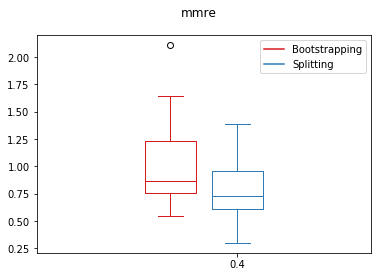

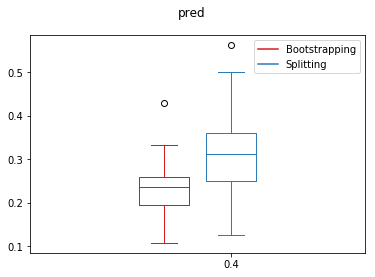

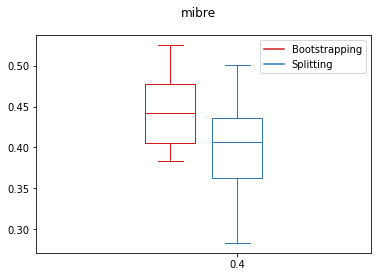

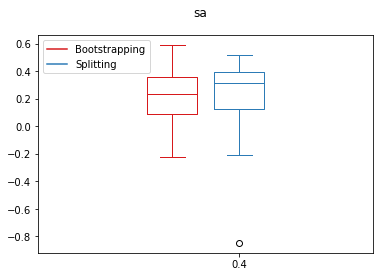

time: 3.11 s


In [7]:
import matplotlib.pyplot as plt
import numpy as np

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

ticks = ['mmre', 'mdmre', 'pred', 'mmer', 'mdmer', 'mae', 'mbre', 'mibre', 'sa']
data_a = list(m_b.values())
data_b = list(m_s.values())

for item in ticks:
    fig, ax = plt.subplots()
    fig.suptitle("{}".format(item))
    bpl = ax.boxplot(m_b[item], positions=[-0.4], widths=0.6)
    bpr = ax.boxplot(m_s[item], positions=[+0.4], widths=0.6)
    set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
    set_box_color(bpr, '#2C7BB6')
    ax.plot([], c='#D7191C', label='Bootstrapping')
    ax.plot([], c='#2C7BB6', label='Splitting')
    ax.legend()
    plt.xlim(-2, 2)

plt.show()